In [18]:
import os
import warnings
from pprint import pprint
import descarteslabs as dl
from osgeo import gdal
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from descarteslabs.client.services import Catalog

In [ ]:
# *************FIND COUNTRY BOUNDARY ***************
matches = dl.places.shape('burundi')
# aoi = matches[0]
# pprint(aoi)
# shape = dl.places.shape(aoi['slug'], geom='low')
print(matches)

In [12]:
night_lights_data_path = "data/marbles/clipped_2.tif"
night_lights_dataset = gdal.Open(night_lights_data_path, gdal.GA_ReadOnly)

In [13]:
geo_transform = night_lights_dataset.GetGeoTransform()
print(geo_transform)
proj = night_lights_dataset.GetProjectionRef()
print(proj)

(54959.18079749914, 351.26393623858894, 0.0, -255368.88164545415, 0.0, -351.26393623858894)
PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]


In [8]:
print(type(night_lights_dataset))

<class 'osgeo.gdal.Dataset'>


## Add Nightlights Image to our catalog

In [14]:
band = night_lights_dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))
      
min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))
      
if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))
      
if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Band Type=Byte
Min=0.000, Max=236.000


data type,   
number of bits needed to store the band data,   
minimum and maximum values for the band,  

option
colormap 
optimal scaling for visualization, and 
define other metadata properties that may be relevant. 

In [28]:
Catalog().add_product('NOAA_VIIRS', 
                      title='NOAA_VIIRS', 
                      description='NOAA VIIRS.'
                     )

{u'data': {u'attributes': {u'description': u'NOAA VIIRS.',
   u'read': [],
   u'title': u'NOAA_VIIRS'},
  u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:NOAA_VIIRS',
  u'meta': {u'owner': {u'email': None,
    u'name': u'Karla King',
    u'uuid': u'google-oauth2|101598335967461239621'},
   u'owner_type': u'user'},
  u'type': u'product'}}

In [29]:
Catalog().add_band(product_id='7294028cc01114d89a473cf055d29dc5cd5ffe88:NOAA_VIIRS',name='gray',srcband=1,nbits=32,dtype='Float32',type='spectral',data_range=[-999.300, 38677.055])['data']['id']

u'7294028cc01114d89a473cf055d29dc5cd5ffe88:NOAA_VIIRS:gray'

image_on_disc = '/Users/karlaking/descarteslabs-code/poverty-predictor/data/SVDNB_npp_d20180403.d.00N060W.rade9.tif'
acquired_date = '2018-04-03'

Catalog().upload_image(image_on_disc,
                       '7294028cc01114d89a473cf055d29dc5cd5ffe88:NOAA_VIIRS',  
                       acquired=acquired_date)

In [5]:
raster_data_path = "data/2298119ene2016recorteTT.tif"
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)

In [15]:
geo_transform = night_lights_dataset.GetGeoTransform()
#     (416415.0, 30.0, 0.0, 6663145.0, 0.0, -30.0)
proj = night_lights_dataset.GetProjectionRef()
#     PROJCS["WGS 84 / UTM zone 20S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32720"]]
bands_data = []
for b in range(1,night_lights_dataset.RasterCount+1):
    band = night_lights_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())
#     [array dtype=float32],[...], ...
bands_data = np.dstack(bands_data)

# Validate data
# rows, cols, n_bands = bands_data.shape
# print (rows, cols, n_bands)

print(night_lights_dataset.RasterCount)

3


In [30]:
rows, cols, n_bands = bands_data.shape

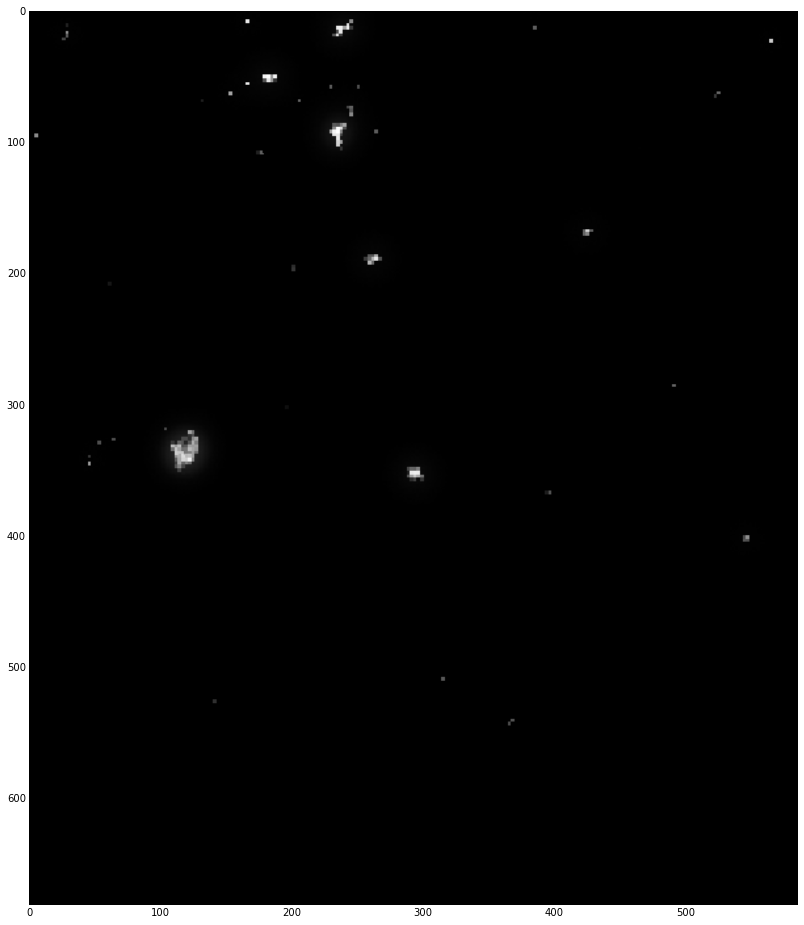

In [17]:
# *************PLOT SINGLE IMAGE ***************

import matplotlib.pyplot as plt
%matplotlib inline


plot_data = bands_data.squeeze()
plot_data.shape



plt.figure(figsize=[16,16])
plt.imshow(plot_data)




### Classification
We need a library of functions to rasterize our training data.

In [24]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    print(vector_data_path)
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    print(data_source)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    print
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

Define training datasets:

In [25]:
output_fname = "data/marbles/night_lights_classification.tiff"
train_data_path = "data/training/night_image/"

In [34]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
# print(classes)
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
print( proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = bands_data[is_train]


data/training/night_image/dark.shp
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x109951090> >
data/training/night_image/light.shp
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x10db8a4b0> >
PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]


In [27]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Let's apply the model to the night lights image for classification.

In [31]:
n_samples = rows*cols
flat_pixels = bands_data.reshape((n_samples, n_bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

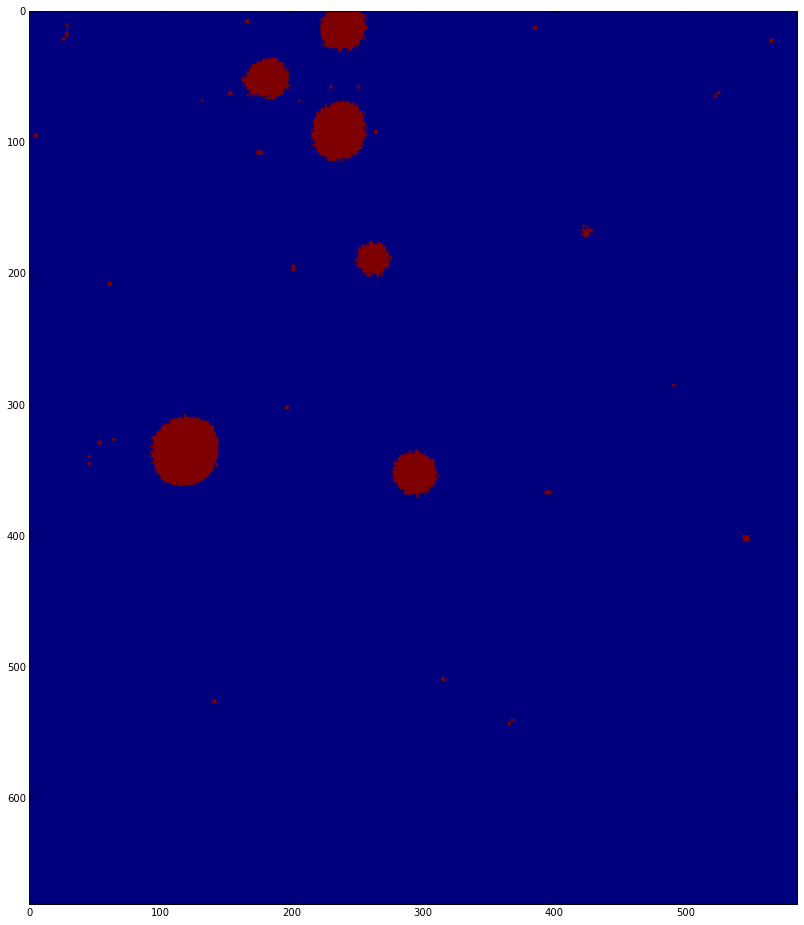

In [32]:
from matplotlib import pyplot as plt

plt.figure(figsize=[16,16])
plt.imshow(classification)

#### Upload Classification to Platform 

Write the file to disc.

In [35]:
band = classification
print("Band Type={}".format(type(band[0][0])))
      
min = np.ndarray.max(band)
max = np.ndarray.min(classification)
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

Band Type=<type 'numpy.float64'>
Min=2.000, Max=1.000


In [39]:
write_geotiff(output_fname, classification, geo_transform, proj)

In [40]:
Catalog().add_product('Burundi_Night_Lights', 
                      title='Burundi_Night_Lights', 
                      description='Test upload.'
                     )

{u'data': {u'attributes': {u'description': u'Test upload.',
   u'read': [],
   u'title': u'Burundi_Night_Lights'},
  u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Night_Lights',
  u'meta': {u'owner': {u'email': None,
    u'name': u'Karla King',
    u'uuid': u'google-oauth2|101598335967461239621'},
   u'owner_type': u'user'},
  u'type': u'product'}}

In [41]:
Catalog().add_band(product_id='7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Night_Lights', name='light', srcband=1, nbits=64,dtype='Float64',type='class',data_range=[1.000,2.000],colormap_name='plasma')


{u'data': {u'attributes': {u'colormap_name': u'plasma',
   u'data_range': [1.0, 2.0],
   u'default_range': None,
   u'dtype': u'Float64',
   u'jpx_layer': 0,
   u'name': u'light',
   u'nbits': 64,
   u'nodata': None,
   u'read': [],
   u'res_factor': 1,
   u'srcband': 1,
   u'srcfile': 0,
   u'type': u'class'},
  u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Night_Lights:light',
  u'meta': {u'owner': {u'email': None,
    u'name': u'Karla King',
    u'uuid': u'google-oauth2|101598335967461239621'},
   u'owner_type': u'user'},
  u'relationships': {u'product': {u'data': {u'id': u'7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Night_Lights',
     u'type': u'product'}}},
  u'type': u'band'}}

In [42]:
image_on_disc = '/Users/karlaking/descarteslabs-code/poverty-predictor/data/marbles/night_lights_classification.tiff'
acquired_date = '2018-04-05'

Catalog().upload_image(image_on_disc,
                       '7294028cc01114d89a473cf055d29dc5cd5ffe88:Burundi_Night_Lights',  
                       acquired=acquired_date)